## КР по курсу "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

In [1]:
import datetime # для работы со временем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

### 1. Чтение данных

In [58]:
df = pd.read_csv(r'C:\Users\Мила\Documents\Web_2\realestatepriceprediction\train.csv')

X = df.drop('Price', axis=1)
y = df['Price']

X_final = pd.read_csv(r'C:\Users\Мила\Documents\Web_2\realestatepriceprediction\test.csv')


print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])


Строк в трейне: 10000
Строк в тесте 5000


In [3]:
X.head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,B,B,33,7976,5,NaN,0,11,B
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,B,B,46,10309,1,240.0,1,16,B


In [4]:
y.head(2)

0    184966.930730
1    300009.450063
Name: Price, dtype: float64

In [5]:
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

In [6]:
X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

In [7]:
# Удалим ненужные файлы
del df
gc.collect()  

97

### 2. EDA. Анализ признаков. Описательная статистика.

Делайем EDA не просто так, а для:
 Исправления выбросов
 Заполнения NaN
 Идей для генерации новых фич


In [8]:
X.dtypes


DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [9]:
X.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


In [10]:
# переведем район в категориальную форму
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

In [11]:
X_obj_features = X.select_dtypes(include='object')
X_obj_features.head()

,DistrictId,Ecology_2,Ecology_3,Shops_2
Id,,,,
14038,35,B,B,B
15053,41,B,B,B
4765,53,B,B,B
5809,58,B,B,B
10783,99,B,B,B


In [12]:
# уникальные переменные
X['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
205      1
117      1
196      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [13]:
X['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [14]:
X['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [15]:
X['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [16]:
X['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
X['KitchenSquare'].value_counts().sort_values()

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

In [18]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [19]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [20]:
(X['Floor'] > X['HouseFloor']).sum()

1825

In [21]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

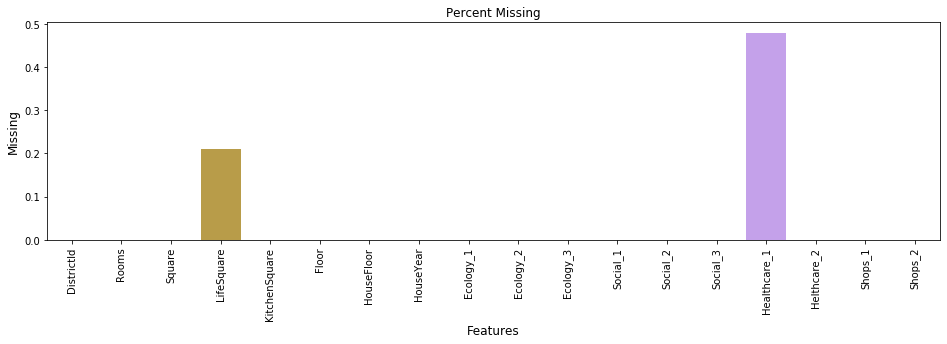

In [22]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()


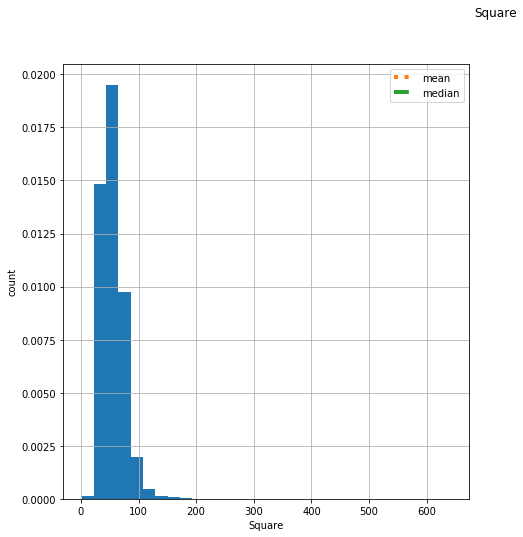

In [23]:
target_mean = round(X['Square'].mean(), 2)
target_median = X['Square'].median()

plt.figure(figsize = (16, 8))
plt.subplot(121)
X['Square'].hist(bins = 30, density=True)
plt.ylabel('count')
plt.xlabel('Square')

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)

plt.legend()
plt.suptitle('Square')
plt.show()

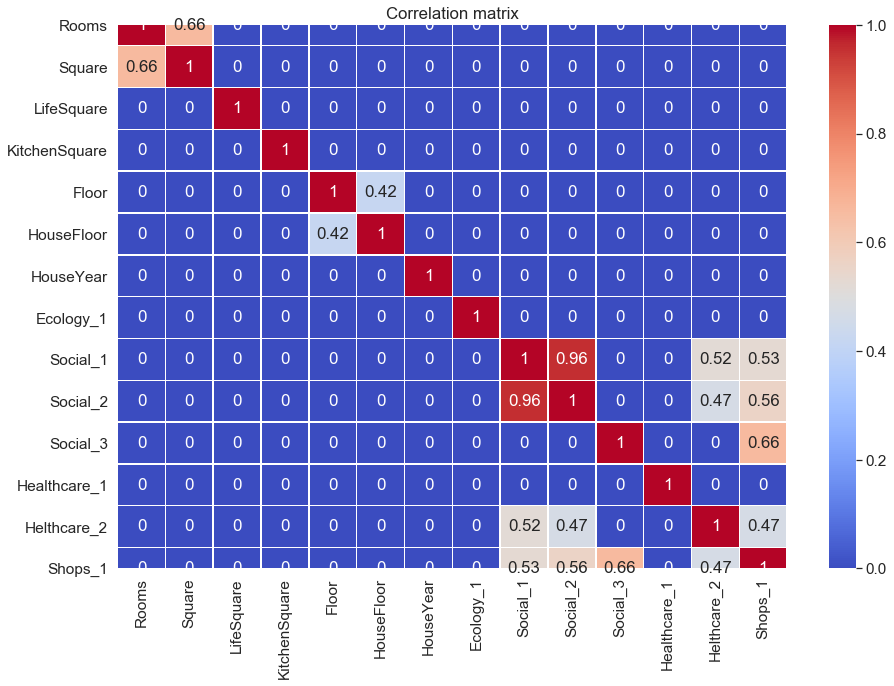

In [24]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()


### 3. Обработка пропусков и выбрасов

In [25]:
X.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [26]:
X.isnull().sum()/X.shape[0]*100

DistrictId        0.00
Rooms             0.00
Square            0.00
LifeSquare       21.13
KitchenSquare     0.00
Floor             0.00
HouseFloor        0.00
HouseYear         0.00
Ecology_1         0.00
Ecology_2         0.00
Ecology_3         0.00
Social_1          0.00
Social_2          0.00
Social_3          0.00
Healthcare_1     47.98
Helthcare_2       0.00
Shops_1           0.00
Shops_2           0.00
dtype: float64

In [27]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '47': 97,
 '13': 97,
 '101': 97,
 '99': 97,
 '7': 92,
 '48': 90,
 '94': 89,
 '29': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '22': 78,
 '2': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '37': 72,
 '90': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '12': 64,
 '128': 64,
 '88': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '31': 55,
 '105': 55,
 '18': 51,
 '119': 49,
 '111': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '63': 43,
 '124': 43,
 '129': 43,
 '79': 42,
 '42': 42,
 '109': 41,
 '113': 41,
 '77': 40,
 '54': 37,
 '38': 36,
 '15': 36,
 '24': 35,
 '56': 34,
 '5': 34,
 '32': 34,
 '103': 33,
 '123': 32,
 '80': 31,
 '19': 31,
 '83': 31,
 '33': 31,
 '130': 29,
 '69': 29,
 '138': 29,
 '64': 28,
 '86': 27,
 '87': 27,
 '70': 27,
 '108': 

In [59]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms - новая фича что это выброс
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        # возможно нежилая или студия
        X['Rooms_out'] = 0
        X.loc[(X['Rooms'] == 0), 'Rooms_out']= 1
        
        # решила не делать X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        # X.loc[X['Rooms'] >= 4, 'Rooms'] = self.medians['Rooms']
        X.loc[X['Rooms'] >= 4, 'Rooms'] = 4

        
        # KitchenSquare
        X['KitchenSquare_out'] = 0
        X.loc[(X['Rooms'] == 0), 'KitchenSquare_out']= 1

        X.loc[(X['KitchenSquare'] < 3) | (X['KitchenSquare'] > 1000), 'KitchenSquare'] = self.medians['KitchenSquare']
                
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        # X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        # X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        proportion_of_floor = X['HouseFloor'].median()/ X['Floor'].median()
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor'] = X.loc[X['Floor'] > X['HouseFloor'],'Floor']*proportion_of_floor
        
        # HouseYear возвращение текущее время и год 
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        #X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = self.medians['HouseYear']
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare 1 если не указана жил.пл.
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        # волнистая черта = не при условии
        # condition = (X['LifeSquare'].isna()) &(~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        
        # X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'LifeSquare'] - X.loc[condition, 'KitchenSquare']
        proportion_of_LifeSquare = X['LifeSquare'].median()/ X['Square'].median()
        X.loc[X['LifeSquare'] == 0, 'LifeSquare'] = X.loc[X['LifeSquare'] == 0, 'Square'] * proportion_of_LifeSquare
       

#        X['FalseSquare'] = 0
#        X.loc[(X['LifeSquare'] / X['Square'])> 1), 'FalseSquare'] = 1     
#        X.loc[(X['LifeSquare'] > 0) & (X['LifeSquare'] / X['Square'])> 1), 'Square'] = X.loc[((X['LifeSquare'] / X['Square'])> 1), 'Square']* proportion_of_LifeSquare
        
        return X


In [60]:
# расчет медиан и фичей, заполнение данных на трейне, и заполнение на тесте по мед. на трейне
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)
X_final = imputer.transform(X_final)

### 4. Отбор и построение новых признаков (фичей)

In [61]:
class FeatureGenetator():
    """Генерация новых фич"""
  # создаем словари районы с домами, 0 или 1 по категориальной бинарной переменной, цена в районе, и цена этаж и год постройки
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_price_by_square = None
        self.med_price_by_shops = None

        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID сопоставление к ID - ID района, т.е. кол-во домов в районе, убираем наблюдения, где меньше 50 в 1 районе
        district = X['DistrictId'].value_counts()
        district = district[district > 50]
        # создаем словарь
        self.DistrictId_counts = dict(district)
        
        # Binary features замена бинарных на 0 и 1
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding - средний таргет по категориальной фиче район + кол-во комнат
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df) # + столбец floor_cat см ниже 
            df = self.year_to_cat(df) # + столбец year_cat см ниже
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        
## square
        if y is not None:
            df['Price'] = y.values
            df = self.square_to_cat(df)             
            self.med_price_by_square = df.groupby(['square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})

## shops
        if y is not None:
            df['Price'] = y.values
            df = self.shops_to_cat(df)             
            self.med_price_by_shops = df.groupby(['shops_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByShops'})

        
    def transform(self, X):
        
        # DistrictId новый столбец в X с кол-вом домов в районе, map это тот же merge, только м\у df и словарем 
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1 # если в словаре район не найден ставим 1
        X['DistrictId_count'].fillna(5, inplace=True) # если значения нет, то 5 (условно малое число)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features создание новых кат. переменных
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        X = self.square_to_cat(X)
        X = self.shops_to_cat(X)
        
        # Target encoding, где  merge слияние 2х df
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.med_price_by_square is not None:
            X = X.merge(self.med_price_by_square, on=['square_cat'], how='left')
        if self.med_price_by_shops is not None:
            X = X.merge(self.med_price_by_shops, on=['shops_cat'], how='left')
 
        # Дополнительные вычисляемые фичи 
        X['Floor_HouseFloor'] = X['Floor']/X['HouseFloor']
        X['Square_Rooms'] = X['Square']/X['Rooms']
        X['Social'] = (X['Social_1']*X['Social_2']*X['Social_3'])/1000
        X['Shops_1_Helthcare_2'] = X['Shops_1']/X['Helthcare_2']
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] <= 1, 'floor_cat'] = 1  
        X.loc[(X['Floor'] > 1) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 16), 'floor_cat'] = 4
        X.loc[X['Floor'] > 16, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
          
    @staticmethod
    def square_to_cat(X):
        
        X['square_cat'] = np.nan
        
        X.loc[X['Square'] < 40, 'square_cat'] = 1
        X.loc[(X['Square'] >= 40) & (X['Square'] <= 50), 'square_cat'] = 2
        X.loc[(X['Square'] > 50) & (X['Square'] <= 65), 'square_cat'] = 3
        X.loc[(X['Square'] > 65) & (X['Square'] <= 80), 'square_cat'] = 4
 
        X.loc[(X['Square'] > 80), 'square_cat'] = 5
            
        return X
    
    @staticmethod
    def shops_to_cat(X):
        
        X['shops_cat'] = np.nan
        
        X.loc[X['Shops_1'] <= 0, 'shops_cat'] = 0
        X.loc[(X['Shops_1'] >= 1) & (X['Shops_1'] <= 3), 'shops_cat'] = 2
        X.loc[(X['Shops_1'] > 3) & (X['Shops_1'] <= 6), 'shops_cat'] = 3
        X.loc[(X['Shops_1'] > 6), 'shops_cat'] = 4
            
        return X


In [62]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [63]:
X.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,square_cat,shops_cat,MedPriceByDistrict,MedPriceByFloorYear,MedPriceBySquare,MedPriceByShops,Floor_HouseFloor,Square_Rooms,Social,Shops_1_Helthcare_2
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,2.0,4.0,NaN,178762.420993,161812.324977,211889.942902,0.777778,23.990781,1316.040,inf
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,4.0,4.0,300009.450063,178762.420993,216181.637056,211889.942902,0.777778,21.894547,474.214,16.0
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968.0,0.049637,...,2.0,2.0,263206.223152,178762.420993,161812.324977,188012.584598,0.666667,22.473976,0.000,3.0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977.0,0.437885,...,3.0,3.0,166809.665642,178762.420993,199612.749059,186911.544028,0.470588,26.676491,395.715,inf
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,1.0,3.0,158539.052715,180613.724418,151274.237796,186911.544028,0.916667,39.649192,202.160,2.0
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011.0,0.309479,...,5.0,3.0,466753.618497,155297.377256,265528.515619,186911.544028,0.294118,26.794826,1080.100,inf
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960.0,0.460556,...,3.0,3.0,NaN,176004.740520,199612.749059,186911.544028,0.600000,31.127057,1228.080,5.0
7,11993,74,2.0,80.312926,NaN,6.0,14,26.0,1977.0,0.075779,...,5.0,2.0,243031.695525,180613.724418,265528.515619,188012.584598,0.538462,40.156463,25.866,inf
8,5172,1,2.0,64.511437,NaN,6.0,9,17.0,1977.0,0.007122,...,3.0,2.0,202706.090239,178762.420993,199612.749059,188012.584598,0.529412,32.255719,0.000,inf
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014.0,0.075779,...,2.0,2.0,102069.270740,170167.793130,161812.324977,188012.584598,0.764706,46.461409,25.866,inf


In [49]:
X.dtypes

Id                         int64
DistrictId                 int64
Rooms                    float64
Square                   float64
LifeSquare               float64
KitchenSquare            float64
Floor                      int64
HouseFloor               float64
HouseYear                float64
Ecology_1                float64
Ecology_2                float64
Ecology_3                float64
Social_1                   int64
Social_2                   int64
Social_3                   int64
Helthcare_2                int64
Shops_1                    int64
Shops_2                  float64
DistrictId_count         float64
new_district               int64
floor_cat                float64
year_cat                 float64
square_cat               float64
shops_cat                float64
MedPriceByDistrict_x     float64
MedPriceByFloorYear_x    float64
MedPriceBySquare_x       float64
MedPriceByShops_x        float64
Floor_HouseFloor         float64
MedPriceByDistrict_y     float64
MedPriceBy

In [68]:
remain_features = ['Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                   'Ecology_1','DistrictId_count', 'MedPriceByDistrict', 'MedPriceByFloorYear',
                  'Square_Rooms', 'Social', 'Social_1', 'Social_2', 'Social_3', 'Shops_1_Helthcare_2', 'Floor_HouseFloor']

X = X [remain_features]
X_final = X_final[remain_features]

In [34]:
### 4. Модель
model = LGBMRegressor(
                             random_state=42)
params = {'min_samples_leaf':[3, 5, 7, 8, 9, 10, 11],
    'n_estimators':[100, 200, 250, 300, 400],
         'max_depth':[3, 5, 7, 8, 9, 10, 11]}

gs = GridSearchCV(model, params,
                 scoring='r2', # метрика
                 cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                          random_state=42,
                          shuffle=True),  n_jobs=-1  # Кол-во потоков на компьютере
                )
gs.fit(X, y)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8, 9, 10, 11],
                         'min_samples_leaf': [3, 5,

In [36]:
gs.best_params_

{'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 200}

In [69]:
model = LGBMRegressor(max_depth=10,
                             min_samples_leaf=3,
                             n_estimators=200,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.746 +- 0.024


In [70]:
# Обучаю модель на всем трейне
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=3,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

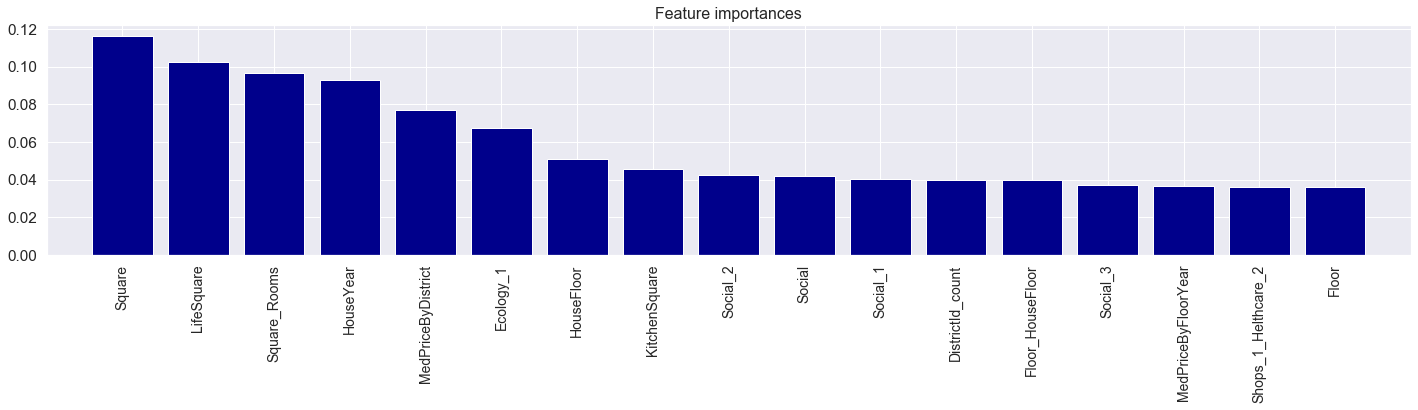

In [71]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [72]:
y_pred_final = model.predict(X_final)

#preds_final = pd.DataFrame()
#preds_final['Id'] = X_final.index
preds_final['Price'] = y_pred_final
preds_final.to_csv(r'C:\Users\Мила\Documents\Web_2\realestatepriceprediction\predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,156701.052452
1,15856,235027.348921
2,5480,237226.653535
3,15664,284893.901701
4,14275,150036.494801


In [73]:
preds_final.shape

(5000, 2)